# Tuning Pipeline

👇 Consider the following dataset.

In [1]:
import pandas as pd

data = pd.read_csv("data.csv")

data.head()

,games played,minutes played,points per game,field goals made,field goal attempts,field goal percent,3 point made,3 point attempt,3 point %,free throw made,free throw attempts,free throw %,offensive rebounds,defensive rebounds,rebounds,assists,steals,blocks,turnovers,target_5y
0,36.0,27.4,7.4,2.6,7.6,NaN,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
1,35.0,26.9,NaN,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
2,NaN,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
3,58.0,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
4,48.0,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1


In [2]:
data.shape

(1340, 20)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   games played         1336 non-null   float64
 1   minutes played       1340 non-null   float64
 2   points per game      1339 non-null   float64
 3   field goals made     1339 non-null   float64
 4   field goal attempts  1338 non-null   float64
 5   field goal percent   1338 non-null   float64
 6   3 point made         1339 non-null   float64
 7   3 point attempt      1338 non-null   float64
 8   3 point %            1328 non-null   float64
 9   free throw made      1340 non-null   float64
 10  free throw attempts  1340 non-null   float64
 11  free throw %         1340 non-null   float64
 12  offensive rebounds   1339 non-null   float64
 13  defensive rebounds   1339 non-null   float64
 14  rebounds             1339 non-null   float64
 15  assists              1340 non-null   f

In [4]:
data.isnull().sum()/len(data)

games played           0.002985
minutes played         0.000000
points per game        0.000746
field goals made       0.000746
field goal attempts    0.001493
field goal percent     0.001493
3 point made           0.000746
3 point attempt        0.001493
3 point %              0.008955
free throw made        0.000000
free throw attempts    0.000000
free throw %           0.000000
offensive rebounds     0.000746
defensive rebounds     0.000746
rebounds               0.000746
assists                0.000000
steals                 0.000000
blocks                 0.000746
turnovers              0.000000
target_5y              0.000000
dtype: float64

In [5]:
# ====> no feture contains more than 1 % Null 

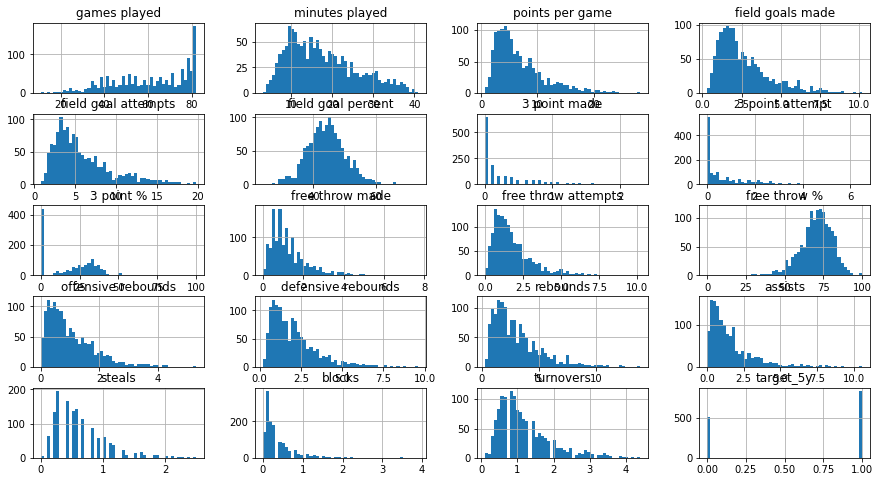

In [6]:
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(15,8))
plt.show()

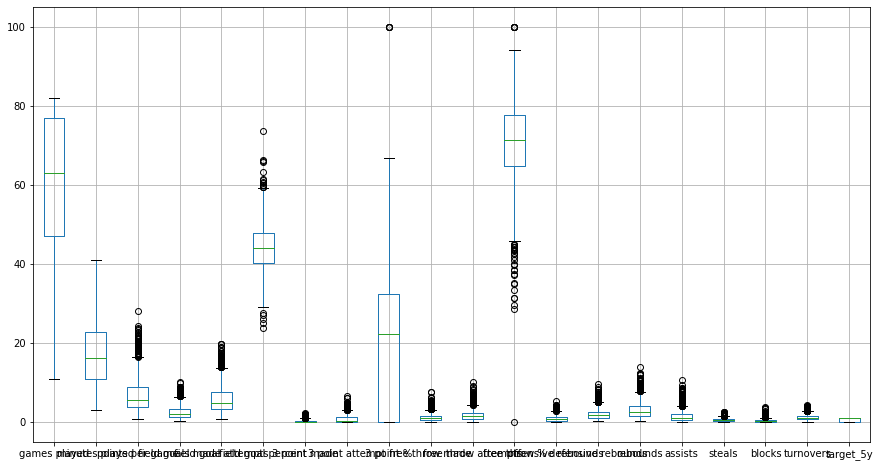

In [7]:
data.boxplot(figsize=(15, 8))
plt.show()

In [8]:
X = data.drop(columns='target_5y')
y = data['target_5y']

In [9]:
y.value_counts()/len(y)  # check class balance ====> imbalance

1    0.620149
0    0.379851
Name: target_5y, dtype: float64

Each observations represents a player and each column a characteristic of performance. The target defines whether the player last less than 5 years [0] or 5 years or more [1] as a professional.

The task is to build a model to assist the recruitment process of promising young players. The model should limit false alarms as much as possible to avoid recruiting players that will flop.

👇 In a pipeline:

- Impute missing values using a `SimpleImputer` an find out which strategy works best
- Scale the features
- Model with an `svm.SVC` and tune its parameters `C` and `kernel` using a `RandomSearch`
- Use the scoring metric appropriate for the task

Once you have built your optimal pipeline, export it as a pickle file.

## Pipeline

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

preprocessor = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())
])

In [11]:
from sklearn.svm import SVC

final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

In [12]:
from sklearn import set_config; set_config(display='diagram')

In [13]:
final_pipe

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('classifier', SVC())])

## Random Search

In [14]:
final_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())])),
  ('classifier', SVC())],
 'verbose': False,
 'preprocessor': Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())]),
 'classifier': SVC(),
 'preprocessor__memory': None,
 'preprocessor__steps': [('imputer', SimpleImputer()),
  ('scaler', MinMaxScaler())],
 'preprocessor__verbose': False,
 'preprocessor__imputer': SimpleImputer(),
 'preprocessor__scaler': MinMaxScaler(),
 'preprocessor__imputer__add_indicator': False,
 'preprocessor__imputer__copy': True,
 'preprocessor__imputer__fill_value': None,
 'preprocessor__imputer__missing_values': nan,
 'preprocessor__imputer__strategy': 'mean',
 'preprocessor__imputer__verbose': 0,
 'preprocessor__scaler__clip': False,
 'preprocessor__scaler__copy': True,
 'preprocessor__scaler__feature_range': (0, 1),
 'classifier__C': 1.0,
 'classifier__break_ties': False,
 'classifier__cache_size': 200,
 'classifi

In [15]:
from sklearn.model_selection import cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

# Hyperparameter Grid
grid = {'preprocessor__imputer__strategy': ['mean', 'median','most_frequent'],
        'classifier__C': stats.uniform(1, 10), 
        'classifier__kernel': ['rbf', 'poly', 'sigmoid'],
        'classifier__degree': [2, 3, 4, 6]
       }

# Instanciate Grid Search
search = RandomizedSearchCV(final_pipe, 
                            grid, 
                            scoring='precision',
                            n_iter=100,  # number of draws
                            cv=5, n_jobs=-1)

In [17]:
search.fit(X_train, y_train)
search.best_params_

{'classifier__C': 1.683461903614101,
 'classifier__degree': 2,
 'classifier__kernel': 'poly',
 'preprocessor__imputer__strategy': 'median'}

In [18]:
optimal_pipeline = search.best_estimator_
optimal_pipeline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])),
                ('classifier',
                 SVC(C=1.683461903614101, degree=2, kernel='poly'))])

In [19]:
optimal_pipeline.score(X_test, y_test)

0.7338308457711443

In [20]:
cross_val_score(optimal_pipeline, X_train, y_train, cv=5, scoring='precision').mean()

0.7473263755521821

In [21]:
cross_val_score(optimal_pipeline, X_train, y_train, cv=5, scoring='f1').mean()

0.750208904118316

## Export

In [22]:
import pickle

# Export pipeline as pickle file
with open("optimal_pipeline.pkl", "wb") as file:
    pickle.dump(optimal_pipeline, file)

In [23]:
reloaded_opt_pipe = pickle.load(open('optimal_pipeline.pkl', 'rb'))
reloaded_opt_pipe.score(X_test, y_test)

0.7338308457711443